# Speech Emotion Recognition

## Imports

In [20]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

### split data

In [30]:
def split(emotion):
    path = "./" + emotion +"/" + emotion
    audio = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
    train_files, test_files = train_test_split(audio, test_size=0.3, random_state=30)

    train = "./training/" + emotion
    test = "./testing/" + emotion

    for file_path in train_files:
        file_name = os.path.basename(file_path)
        new_path = os.path.join(train, file_name)
        shutil.copy(file_path, new_path)

    for file_path in test_files:
        file_name = os.path.basename(file_path)
        new_path = os.path.join(test, file_name)
        shutil.copy(file_path, new_path)

split("angry")
split("happy")
split("sad")
split("fear")

## Exploratory Data Analysis

In [40]:
def display(path):
    
    signal, sample_rate = librosa.load(path)

    # plot audio files in time domain
    plt.figure(1)
    librosa.display.waveshow(y=signal, sr=sample_rate)
    plt.xlabel('Time / second')
    plt.ylabel('Amplitude')
    plt.show()

Angry:


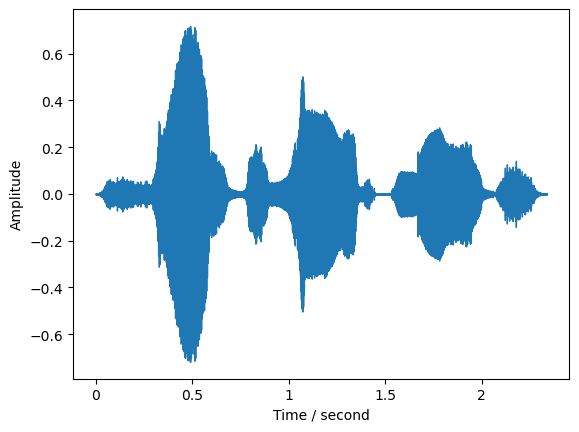

Happy:


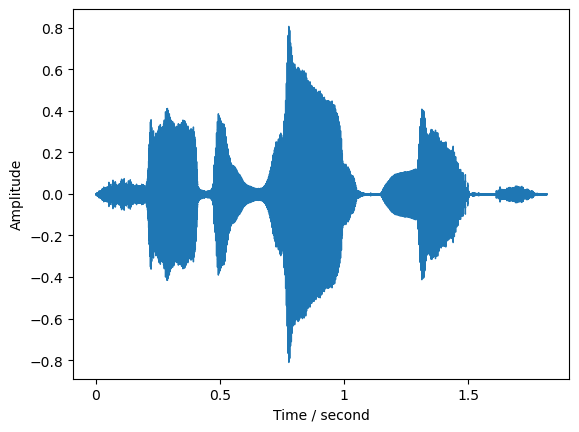

In [41]:
print("Angry:")
display("./angry/angry/YAF_merge_angry.wav")

print("Happy:")
display_graphs("./happy/happy/YAF_met_happy.wav")

## Acoustic Feature Extraction.

In [42]:
def extract(emotion):
    path = "./" + emotion +"/" + emotion
    audio = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
    return(audio)

angry = extract("angry")
happy = extract("happy")
sad = extract("sad")
fear = extract("fear")

train_concat = np.concatenate((angry, happy, sad, fear))

def extract_test(emotion):
    path = "./" + emotion +"/" + emotion
    audio = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
    return(audio)

angry_test = extract_test("angry")
happy_test = extract_test("happy")
sad_test = extract_test("sad")
fear_test = extract_test("fear")

test_concat = np.concatenate((angry_test, happy_test, sad_test, fear_test))

## Feature Post-processing

In [45]:
from sklearn.preprocessing import MinMaxScaler
def features(audio):
    matrix = []
    
    for i in audio:
        signal, sample_rate = librosa.load(i)

        # audio feature extraction: loudness
        df_loudness = pd.DataFrame()
        S, phase = librosa.magphase(librosa.stft(signal))
        rms = librosa.feature.rms(S=S)
        df_loudness['Loudness'] = rms[0]
        
        # audio feature extraction: mel-frequency cepstral coefficients
        df_mfccs = pd.DataFrame()
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)
        for n_mfcc in range(len(mfccs)):
            df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
        
        
        feature_matrix = pd.concat([df_loudness, df_mfccs], axis=1)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(feature_matrix)
        scaled_df = pd.DataFrame(scaled_data, columns=feature_matrix.columns)
        
        mean = scaled_df.mean()
        result = mean.to_numpy()
        matrix.append(result)
        
    return(matrix)

X_train = features(train_concat)
X_test = features(test_concat)


In [46]:
# 0 = ANGRY, 1 = HAPPY, 2 = SAD, 3 = FEAR
zero = np.zeros(len(angry))
one = np.ones(len(happy))
two = np.full(len(sad), 2)
three = np.full(len(fear), 3)

y_train = np.concatenate((zero, one, two, three))

zero = np.zeros(len(angry_test))
one = np.ones(len(happy_test))
two = np.full(len(sad_test), 2)
three = np.full(len(fear_test), 3)

y_test = np.concatenate((zero, one, two, three))

## Build Models

In [49]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

svc = SVC(probability=True)
nbc = GaussianNB()

svc.fit(X_train, y_train)
nbc.fit(X_train, y_train)

y_svc_predicted = svc.predict(X_test)
y_svc_pred_proba = svc.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_nbc_predicted))

              precision    recall  f1-score   support

         0.0       0.61      0.73      0.67       100
         1.0       0.74      0.64      0.69       100
         2.0       0.90      0.96      0.93       100
         3.0       0.73      0.64      0.68       100

    accuracy                           0.74       400
   macro avg       0.75      0.74      0.74       400
weighted avg       0.75      0.74      0.74       400

              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66       100
         1.0       0.74      0.76      0.75       100
         2.0       0.91      0.96      0.94       100
         3.0       0.76      0.63      0.69       100

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400

